In [6]:
import pandas as pd
import numpy as np

In [7]:
df = pd.read_csv("weatherAUS_clean.csv")
print(df.shape)
df.head()

(123710, 31)


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,spring,summer,autumn,winterRain,springRain,summerRain,autumnRain,latitude,longitude,RainTomorrow
0,13.4,22.9,0.6,4.8,8.6,44.0,20.0,24.0,71.0,22.0,...,False,False,False,False,False,False,False,-36.080477,146.91628,0
1,7.4,25.1,0.0,4.8,8.6,44.0,4.0,22.0,44.0,25.0,...,False,False,False,False,False,False,False,-36.080477,146.91628,0
2,12.9,25.7,0.0,4.8,8.6,46.0,19.0,26.0,38.0,30.0,...,False,False,False,False,False,False,False,-36.080477,146.91628,0
3,9.2,28.0,0.0,4.8,8.6,24.0,11.0,9.0,45.0,16.0,...,False,False,False,False,False,False,False,-36.080477,146.91628,0
4,17.5,32.3,1.0,4.8,8.6,41.0,7.0,20.0,82.0,33.0,...,False,False,False,False,False,False,False,-36.080477,146.91628,0


In [8]:
target = "RainTomorrow"
features = ['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday',
 'Year',
 'Month',
 'Day',
 'winter',
 'spring',
 'summer',
 'autumn',
 'winterRain',
 'springRain',
 'summerRain',
 'autumnRain',
 'latitude',
 'longitude']


In [9]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


# Przygotujmy wrapper
def CVTestRFClass(nFolds = 5, randomState=2020, debug=False, features=features, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # listy do przechowywania wyników:
    testResults = []
    trainResults = []
    predictions = []
    indices = []

    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = RandomForestClassifier(*args, **kwargs, random_state=randomState, n_jobs=-1)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA Sklearn zwracał będzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Policzenie dopasowania za pomocą metryki ROC-AUC
        trainScore = roc_auc_score((df[target].iloc[train]).astype(int), predsTrain)
        testScore = roc_auc_score((df[target].iloc[test]).astype(int), preds)
        
        # Zapisanie wyników do listy 
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices


In [10]:
trainResults, testResults, predictions, indices = CVTestRFClass(debug=True)
print(np.mean(testResults))

RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 0.9999999994070048 Valid AUC: 0.893063504420972
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 1.0 Valid AUC: 0.8947233371249379
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 0.9999999997043721 Valid AUC: 0.8969430910976026
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 0.9999999994083014 Valid AUC: 0.8928959660698224
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 1.0 Valid AUC: 0.8940375683903938
0.8943326934207458


In [11]:
import random
results=[]
paramList = []
for x in range(20):
    params = {"depth": random.randint(3, 16), 
              "estimators": random.randint(100, 300), 
              "features": random.randint(2, 25), 
              "samples_split": random.randint(2, 10), 
              "samples_leaf": random.randint(2, 10)
              }
    
    trainResults, testResults, predictions, indices = CVTestRFClass(
        max_depth=params['depth'],
        n_estimators=params['estimators'],
        max_features=params['features'],
        min_samples_split=params['samples_split'],
        min_samples_leaf=params['samples_leaf'],
        )
    
    print(np.mean(testResults), params)
    results.append(np.mean(testResults))
    paramList.append(params)

0.8756253542921535 {'depth': 12, 'estimators': 247, 'features': 2, 'samples_split': 8, 'samples_leaf': 8}
0.8914439006702647 {'depth': 14, 'estimators': 273, 'features': 13, 'samples_split': 3, 'samples_leaf': 6}
0.8930815444724521 {'depth': 16, 'estimators': 168, 'features': 22, 'samples_split': 9, 'samples_leaf': 4}
0.8514069604128682 {'depth': 4, 'estimators': 118, 'features': 6, 'samples_split': 3, 'samples_leaf': 10}
0.8680950408559488 {'depth': 7, 'estimators': 104, 'features': 6, 'samples_split': 5, 'samples_leaf': 4}
0.8882710763501784 {'depth': 12, 'estimators': 139, 'features': 25, 'samples_split': 6, 'samples_leaf': 9}
0.8636020780596493 {'depth': 6, 'estimators': 130, 'features': 6, 'samples_split': 5, 'samples_leaf': 7}
0.844004900327386 {'depth': 3, 'estimators': 172, 'features': 22, 'samples_split': 7, 'samples_leaf': 2}
0.8542263267982781 {'depth': 5, 'estimators': 134, 'features': 4, 'samples_split': 8, 'samples_leaf': 3}
0.8752695319203638 {'depth': 8, 'estimators': 2

In [12]:
    trainResults, testResults, predictions, indices = CVTestRFClass(
        max_depth=14,
        n_estimators=500,
        max_features=23,
        min_samples_split=6,
        min_samples_leaf=4,
        )
    
    print(np.mean(testResults))

0.8920154567424963


In [13]:
resultRF = {
    "name":"Random Forest",
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

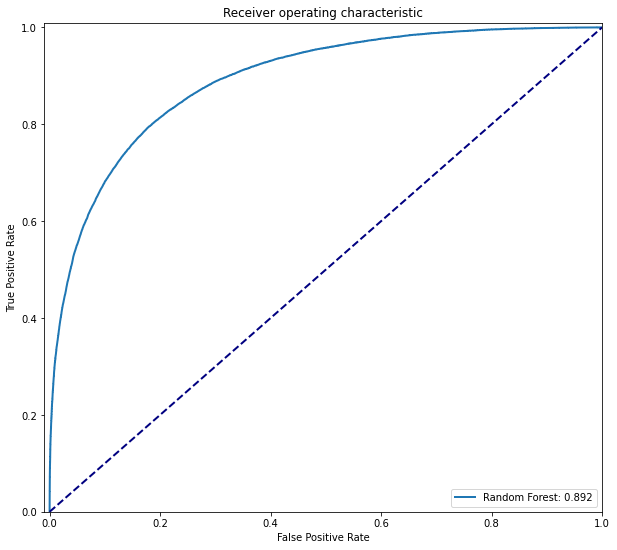

In [14]:
res2plot = []
true = (df[target]).astype(int).sort_index()
for result in [resultRF]:
    # Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))

from helpers import plotROCs
plotROCs(res2plot)

In [15]:
import pickle

# Otwieramy plik do zapisu binarnego z wykorzystenim with
with open("result_RF.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(resultRF, fp)